# TI3130: Regression Lab &mdash; Tutorial
**Julián Urbano &mdash; December 2021**

## 1. Introduction

The purpose of this lab is to introduce you to the [Statsmodels](https://www.statsmodels.org/) package to work with linear models, along with [Plotnine](https://plotnine.readthedocs.io/) for diagnosing. Contrary to other packages, Statsmodels has powerful modeling capabilities that will simplify enormously the process of model specification and refinement.

In [1]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__)

python 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)] 
numpy 1.21.2 
pandas 1.3.4 
plotnine 0.8.0 
statsmodels 0.13.0


As we did in previous labs, we will use the _Amsterdam lite_ dataset, which contains several data from neighborhoods in the city:

In [2]:
ams = pd.read_csv('amsterdam_lite.csv')
ams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neighborhood      413 non-null    object 
 1   district          413 non-null    object 
 2   year              413 non-null    int64  
 3   fac_culture       413 non-null    int64  
 4   fac_sports        413 non-null    int64  
 5   fac_health        413 non-null    int64  
 6   fac_welfare       413 non-null    int64  
 7   fac_schools       413 non-null    int64  
 8   hou_corporation   413 non-null    int64  
 9   hou_occupant      413 non-null    int64  
 10  hou_other         413 non-null    int64  
 11  hou_value         413 non-null    int64  
 12  inc_income        413 non-null    int64  
 13  inc_gini          413 non-null    float64
 14  pop_total         413 non-null    int64  
 15  pop_unemployed    413 non-null    int64  
 16  saf_neighbors     413 non-null    object 
 1

## 2. Simple Linear Regression

In our data, it looks like there is a relationship between `hou_value` (mean house value) and `inc_income` (mean disposable income):

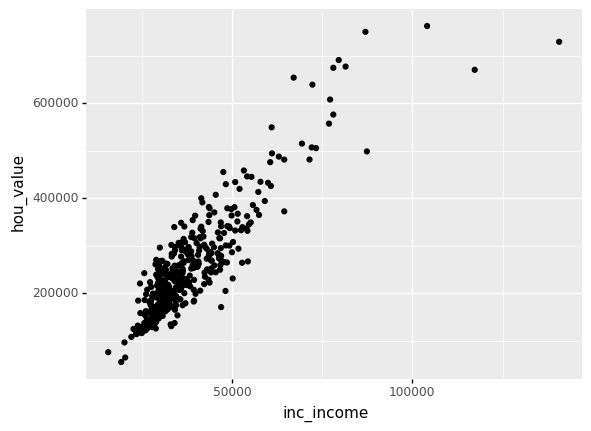

<ggplot: (162619094824)>

In [3]:
# Note how we build a ggplot scatterplot of the data and save it into a variable g
# This will allow us later on to add layers on top of the scatterplot more easily,
# for instance to see how well a model fits the data or to compare several models
g = ggplot(ams, aes('inc_income', 'hou_value')) + \
    geom_point()
g # this will show the plot

Let us fit a simple linear model around these variables. Statsmodels allows us to fit linear models through method [`ols`](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html). Two arguments are needed to build a model: a data frame with the data, and the model specification. To specify a model, the [formula API](https://www.statsmodels.org/stable/example_formulas.html) in Statsmodels allows us to follow a syntax similar to that of a formula: `y ~ x` means that the dependent variable `y` is modeled as a function of (`~`) independent variable `x`. Let’s specify a model and fit it to our data by calling [`fit`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.fit.html). We look at the coefficients with method [`summary`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.summary.html):

In [4]:
m = smf.ols('hou_value ~ inc_income', ams).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hou_value   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1650.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          5.67e-146
Time:                        02:27:48   Log-Likelihood:                -5052.6
No. Observations:                 413   AIC:                         1.011e+04
Df Residuals:                     411   BIC:                         1.012e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.926e+04   7366.600     -3.972      0.000   -4.37e+04   -1.48e+04
inc_income     7.3901      0.182     40.617      0.000       7.032       7.748
==============================================================================
Omnibus:                       32.395   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.922
Skew:                          -0.003   Prob(JB):                     1.12e-30
Kurtosis:                       5.831   Cond. No.                     1.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary of the model already gives us a lot of information, mainly:

- Rough description of the shape of the distribution of residuals (skewness and kurtosis). We can access residuals directly through `m.resid`.
- Estimated coefficients, their standard errors, $t$- and $p$-values and the 95% confidence intervals. We can access the estimates directly with `m.params`, and their full statistical summary with `m.summary().tables[1]`.
- Statistics of model accuracy and goodness of fit, such as $R^2$. Built-in statistics can be accessed with `m.rsquared`, `m.rsquared_adj`, `m.aic` or `m.bic`.

We can see a statistically significant relationship between `hou_value` and `inc_income`, as well as an intercept, interpreted as the expected `hou_value` when someone makes no money (ie. `inc_income=0`).

The model `summary` gives us standard errors, the $t$-tests for the hypotheses $\beta_j=0$ and the 95% confidence intervals. We can also compute intervals of arbitrary confidence:

In [5]:
m.conf_int(alpha = 0.01) # 99% confidence

,0,1
Intercept,-48322.437110,-10195.212639
inc_income,6.919212,7.860891


The best way to diagnose the model is to plot it. For this, it's best to build a data frame containing the original data, residuals and fitted values. Having everything in a single data frame will make it easier to plot complex models in a consistent manner:

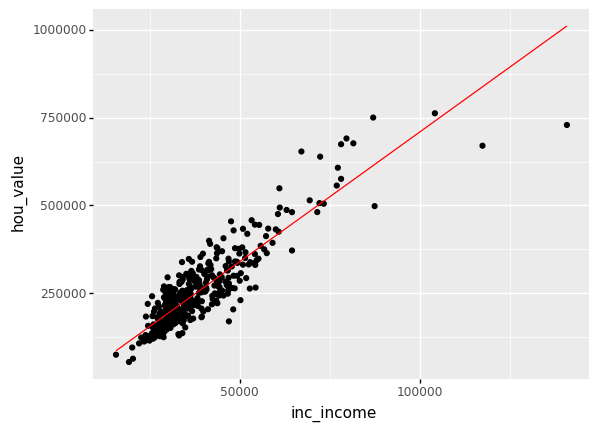

<ggplot: (162619094462)>

In [6]:
d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

g + geom_line(aes(y = '_fitted'), data = d, color = 'red')

It's always a good idea to take a look at the residuals, plot them by fitted value, and make sure there are no patterns that would indicate a bad model fit:

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.


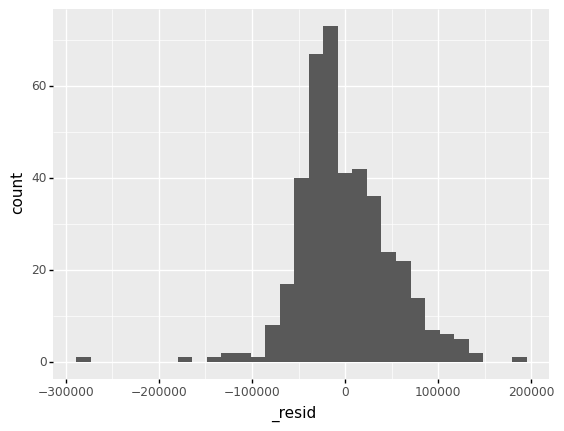

<ggplot: (162619242244)>

In [7]:
ggplot(d, aes('_resid')) +\
    geom_histogram()

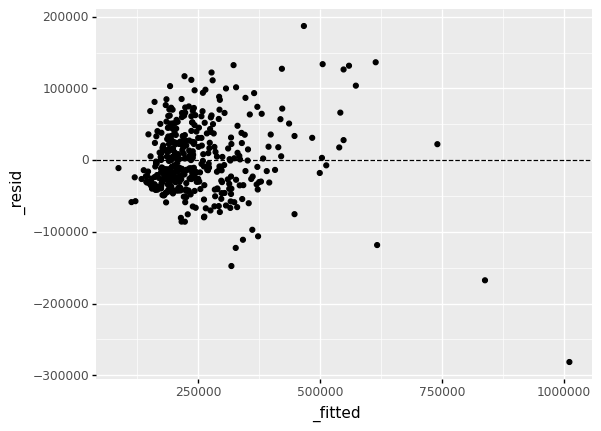

<ggplot: (162619739076)>

In [8]:
ggplot(d, aes('_fitted', '_resid')) +\
    geom_point() +\
    geom_hline(yintercept = 0, linetype = 'dashed')

## 3. Multiple Linear Regression

If we want to include several predictors, we simply concatenate them with `+` when specifying the model in `smf.ols`. Let us build three separate models by including as predictors the number of some facilities in the neighborhoods: `fac_health`, `fac_sports` and `fac_schools`.

In [9]:
m_health = smf.ols('hou_value ~ inc_income + fac_health', ams).fit()
m_health.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.75e+04,7026.296,-5.337,0.000,-5.13e+04,-2.37e+04
inc_income,6.9178,0.183,37.796,0.000,6.558,7.278
fac_health,1454.0735,198.492,7.326,0.000,1063.885,1844.262


In [10]:
m_sports = smf.ols('hou_value ~ inc_income + fac_sports', ams).fit()
m_sports.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.137e+04,7411.764,-4.232,0.000,-4.59e+04,-1.68e+04
inc_income,7.3334,0.183,39.987,0.000,6.973,7.694
fac_sports,4290.9837,2113.475,2.030,0.043,136.385,8445.582


In [11]:
m_schools = smf.ols('hou_value ~ inc_income + fac_schools', ams).fit()
m_schools.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.733e+04,8232.132,-3.319,0.001,-4.35e+04,-1.11e+04
inc_income,7.3763,0.184,40.095,0.000,7.015,7.738
fac_schools,-1617.2362,3064.274,-0.528,0.598,-7640.885,4406.413


**Keep in mind that `+` does not mean _arithmetic addition_. It’s just a special syntax to specify model terms (more details below).**

We can see that both `fac_health` and `fac_sports` seem to be significantly associated with the response, but `fac_schools` is not. What would happen if we included both factors, apparently significant, into the same model?

In [12]:
m = smf.ols('hou_value ~ inc_income + fac_health + fac_sports', ams).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.728e+04,7062.782,-5.278,0.000,-5.12e+04,-2.34e+04
inc_income,6.9194,0.183,37.751,0.000,6.559,7.280
fac_health,1478.8047,211.120,7.005,0.000,1063.790,1893.820
fac_sports,-736.5983,2124.442,-0.347,0.729,-4912.786,3439.590


Suddenly, and contrary to the model `m_sports` that we fitted above, `fac_sports` is not statistically significant anymore. This is because, once `fac_health` is in the model, adding `fac_sports` does not significantly improve the fit. This does _not_ mean that `fac_sports` is not a good predictor in its own (it is, as we saw in `m_sports`); it is just correlated with `fac_health` and adds little information to the model. This is precisely what happened above with model `m_shcools`; compare it with a model that has `fac_schools` as sole predictor.

In addition, keep in mind that we are considering an effect statistically significant if its corresponding $p$-value is less than 0.05, which is an arbitrary threshold anyway. Statistics of coefficient precision depend on what variables there are in the model, so setting a hard threshold like this will lead to somewhat contradictory results when interpreting significance as binary (ie. as _yes_ vs _no_).

The model we have so far achieves $R^2$=0.824, which is quite good. Let us add more predictors to try and get a better fit:

In [13]:
m = smf.ols('hou_value ~ inc_income + fac_health + fac_sports + hou_occupant + inc_gini', ams).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hou_value   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     494.0
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.52e-170
Time:                        02:27:49   Log-Likelihood:                -4981.7
No. Observations:                 413   AIC:                             9975.
Df Residuals:                     407   BIC:                         1.000e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -8.574e+04   1.08e+04     -7.970      0.000   -1.07e+05   -6.46e+04
inc_income       5.7512      0.247     23.314      0.000       5.266       6.236
fac_health    1424.5361    243.841      5.842      0.000     945.190    1903.882
fac_sports    -749.8487   1930.373     -0.388      0.698   -4544.595    3044.898
hou_occupant   -49.0499     10.177     -4.820      0.000     -69.056     -29.044
inc_gini      3.874e+05    5.6e+04      6.920      0.000    2.77e+05    4.97e+05
==============================================================================
Omnibus:                      105.273   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1379.059
Skew:                          -0.667   Prob(JB):                    3.48e-300
Kurtosis:                      11.852   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2$ now increases slightly to 0.859, but let’s diagnose the model.

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 46'. Pick better value with 'binwidth'.


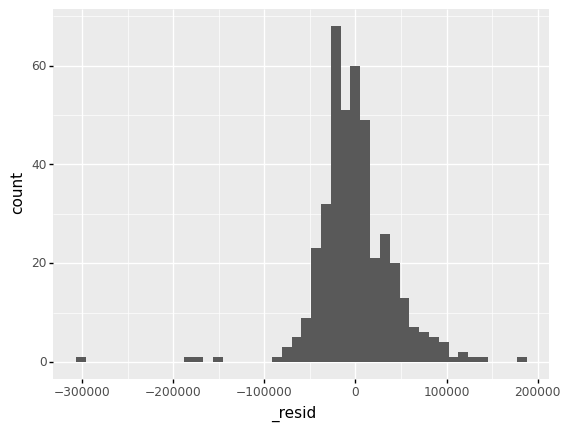

<ggplot: (162619787502)>

In [14]:
d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

ggplot(d, aes('_resid')) +\
    geom_histogram()

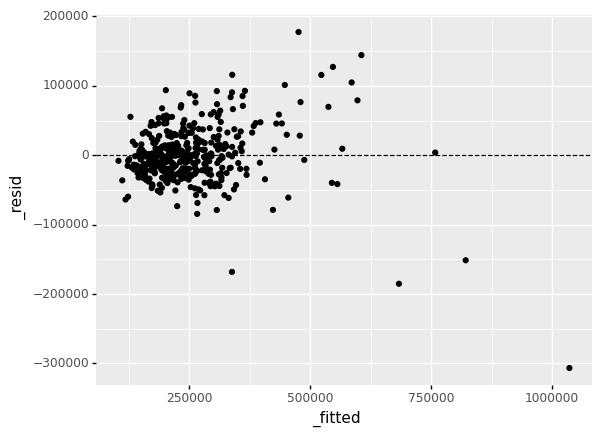

<ggplot: (162619794047)>

In [15]:
ggplot(d, aes('_fitted', '_resid')) +\
    geom_point() +\
    geom_hline(yintercept = 0, linetype = 'dashed')

The histogram shows that residuals seem to be a bit asymmetric, which could suggest the need for transformation. The scatterplot shows a few outliers at high values, as well as some signs of heteroskedasticity. Some kind of transformation will probably improve this model (see below).

Does it make sense to plot the predictions as a function of one of the predictors alone, say `fac_health`?

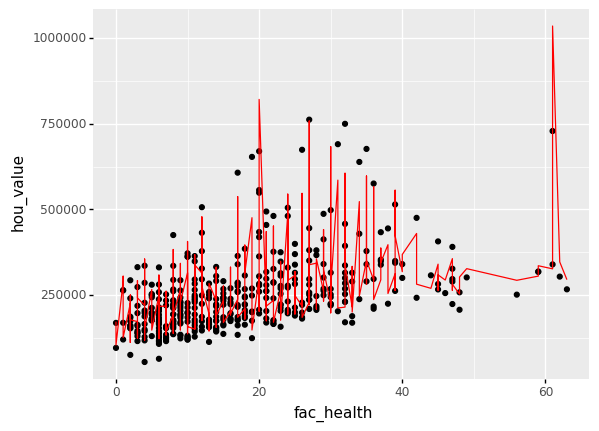

<ggplot: (162619843386)>

In [16]:
ggplot(d, aes('fac_health', 'hou_value')) +\
  geom_point() +\
  geom_line(aes(y = '_fitted'), color = 'red')

Remember that, in multiple regression, we assume that _"everything else is held constant"_. In the plot above we don't see a straight line for the effect of `fac_health`, because the other variables also affect the response at the same time. We may consider [partial residual plots](https://en.wikipedia.org/wiki/Partial_residual_plot) to get a better idea of the effect of one predictor in the model, but this is out of scope for this lab.

Just as before, we can compute confidence intervals around the coefficients if we're interested:

In [17]:
m.conf_int()

,0,1
Intercept,-106882.946327,-64587.822433
inc_income,5.266226,6.236106
fac_health,945.190428,1903.881820
fac_sports,-4544.595003,3044.897652
hou_occupant,-69.056089,-29.043653
inc_gini,277325.310036,497401.920213


## 4. Nominal Predictors

If one of our predictors is nominal or categorical, Statsmodels will deal with dummy variables for us. We just specify the model as usual. Let us look at the possible effect of `spa_green` on `hou_value`:

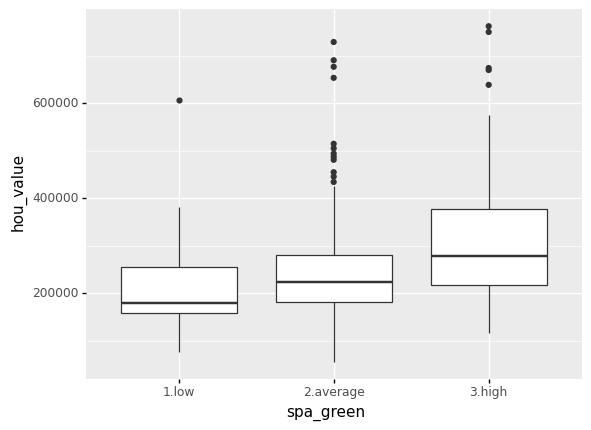

<ggplot: (162619745832)>

In [18]:
ggplot(ams, aes('spa_green', 'hou_value')) +\
  geom_boxplot()

In [19]:
m = smf.ols('hou_value ~ spa_green', ams).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hou_value   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     16.55
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           1.22e-07
Time:                        02:27:50   Log-Likelihood:                -5369.5
No. Observations:                 413   AIC:                         1.075e+04
Df Residuals:                     410   BIC:                         1.076e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.134e+05   1.57e+04     13.600      0.000    1.83e+05    2.44e+05
spa_green[T.2.average]  2.876e+04    1.7e+04      1.697      0.091   -4563.468    6.21e+04
spa_green[T.3.high]     9.662e+04   1.96e+04      4.941      0.000    5.82e+04    1.35e+05
==============================================================================
Omnibus:                      145.447   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.188
Skew:                           1.618   Prob(JB):                    1.08e-103
Kurtosis:                       7.134   Cond. No.                         6.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Remember that the coefficients represent a deviation from the baseline intercept (`1.low` in our case). If we want to explicitly model absolute group intercepts instead of deviations, we can tell Statsmodels to remove the intercept term by adding `+0` or `-1` to the model specification:

In [20]:
m = smf.ols('hou_value ~ spa_green -1', ams).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hou_value   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     16.55
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           1.22e-07
Time:                        02:27:50   Log-Likelihood:                -5369.5
No. Observations:                 413   AIC:                         1.075e+04
Df Residuals:                     410   BIC:                         1.076e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
spa_green[1.low]      2.134e+05   1.57e+04     13.600      0.000    1.83e+05    2.44e+05
spa_green[2.average]  2.422e+05   6417.489     37.735      0.000     2.3e+05    2.55e+05
spa_green[3.high]       3.1e+05   1.17e+04     26.569      0.000    2.87e+05    3.33e+05
==============================================================================
Omnibus:                      145.447   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.188
Skew:                           1.618   Prob(JB):                    1.08e-103
Kurtosis:                       7.134   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compare the coefficient summaries in the two models above. How are they different, and why?

## 5. Interaction Effects

If we want to check whether the relationship between a predictor and the response is influenced by a third predictor, we can ask Statsmodels to model the interaction between both predictors, and it will take care of dummy variables and all the necessary model terms.

Let's model the interaction between numerical variables `inc_income` and `fac_culture` on the response `hou_value`. We can specify the interaction term with operator `:`:

In [21]:
m = smf.ols('hou_value ~ inc_income + fac_culture + inc_income:fac_culture', ams).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hou_value   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     684.9
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          4.90e-159
Time:                        02:27:50   Log-Likelihood:                -5014.7
No. Observations:                 413   AIC:                         1.004e+04
Df Residuals:                     409   BIC:                         1.005e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.572e+04   1.25e+04     -2.861      0.004   -6.03e+04   -1.12e+04
inc_income                 6.8768      0.327     21.003      0.000       6.233       7.520
fac_culture              125.2939    749.227      0.167      0.867   -1347.523    1598.111
inc_income:fac_culture     0.0353      0.020      1.763      0.079      -0.004       0.075
==============================================================================
Omnibus:                       52.632   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.908
Skew:                           0.004   Prob(JB):                     1.08e-91
Kurtosis:                       7.934   Cond. No.                     4.90e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The term `inc_income:fac_culture` corresponds to the interaction effect, which in this case is _not_ statistically significant. The main effect of `fac_culture` also appears to be _not_ significant. What could happen in this case if we removed the interaction effect; how could this affect `fac_culture`? What if we removed the main effect of `fac_culture`; should we do if? Fit the corresponding models and see for yourself.

If we want the interaction between two categorical variables, we specify them in the same way. Let us check for an interaction between `saf_nonneighbors` and `district`:

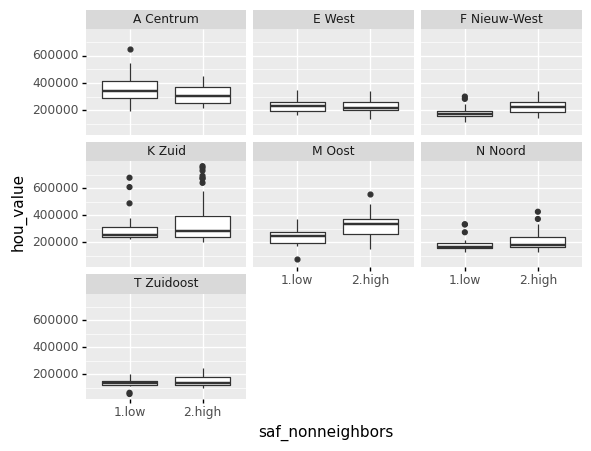

<ggplot: (162619965407)>

In [22]:
ggplot(ams, aes('saf_nonneighbors', 'hou_value')) +\
  geom_boxplot() +\
  facet_wrap('district')

It looks like the difference in `hou_value` between groups `1.low` and `2.high` is not the same across `district`s. Sometimes it is positive, and sometimes it is negative. Let's build a model to confirm that this is not just a random effect of sampling:

In [23]:
m = smf.ols('hou_value ~ saf_nonneighbors + district + saf_nonneighbors:district', ams).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.612e+05,1.57e+04,23.008,0.000,3.3e+05,3.92e+05
saf_nonneighbors[T.2.high],-4.32e+04,3.18e+04,-1.359,0.175,-1.06e+05,1.93e+04
district[T.E West],-1.32e+05,2.01e+04,-6.555,0.000,-1.72e+05,-9.24e+04
district[T.F Nieuw-West],-1.831e+05,2.08e+04,-8.801,0.000,-2.24e+05,-1.42e+05
district[T.K Zuid],-4.26e+04,2.59e+04,-1.645,0.101,-9.35e+04,8324.807
district[T.M Oost],-1.202e+05,2.19e+04,-5.498,0.000,-1.63e+05,-7.72e+04
district[T.N Noord],-1.79e+05,2.3e+04,-7.777,0.000,-2.24e+05,-1.34e+05
district[T.T Zuidoost],-2.288e+05,2.97e+04,-7.700,0.000,-2.87e+05,-1.7e+05
saf_nonneighbors[T.2.high]:district[T.E West],4.22e+04,3.83e+04,1.103,0.271,-3.3e+04,1.17e+05
saf_nonneighbors[T.2.high]:district[T.F Nieuw-West],9.094e+04,3.86e+04,2.355,0.019,1.5e+04,1.67e+05


Several interaction coefficients are indeed statistically significant: the difference in `hou_value` between the groups of `saf_nonneighbors` is not the same across `district`s.

A shortcut to specify main effects and interactions in a model is the operator `*`. Instead of specifying the model as `y ~ x1 + x2 + x1:x2`, we can simply do `y ~ x1*x2`, which means _main effects and interaction_. Of course, we can chain and use more than two predictors, such as `y ~ x1*x2*x3`, which would include the 3 main effects, the 3 2-factor interactions, and the 3-factor interaction.

Finally, the interaction between categorical and numerical variables is specified just the same. Let us first create and save a simple linear model `m0` to compare:

In [24]:
m0 = smf.ols('hou_value ~ fac_health', ams).fit()
m0.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.788e+05,8618.902,20.749,0.000,1.62e+05,1.96e+05
fac_health,4096.7114,392.906,10.427,0.000,3324.355,4869.067


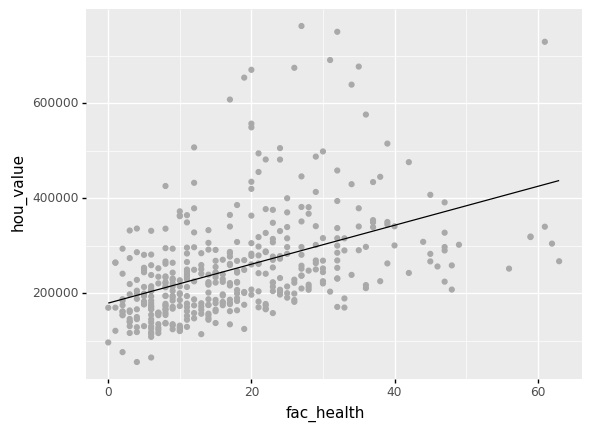

<ggplot: (162619239313)>

In [25]:
d = ams.assign(_resid = m0.resid, _fitted = m0.fittedvalues)

# Note how we use ams as main data frame for the plot (eg. used by geom_point),
# but use d only for geom_line
g0 = ggplot(ams, aes('fac_health', 'hou_value')) +\
  geom_point(color = 'darkgrey') +\
  geom_line(aes(y = '_fitted'), data = d, color = 'black')
g0

We can model one common slope for `fac_health`, but three different intercepts based on `spa_streets`:

In [26]:
m = smf.ols('hou_value ~ fac_health + spa_streets', ams).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.568e+05,1.04e+04,15.066,0.000,1.36e+05,1.77e+05
spa_streets[T.2.average],3.309e+04,1.12e+04,2.959,0.003,1.11e+04,5.51e+04
spa_streets[T.3.high],9.254e+04,1.58e+04,5.870,0.000,6.16e+04,1.24e+05
fac_health,3496.7790,393.281,8.891,0.000,2723.675,4269.883


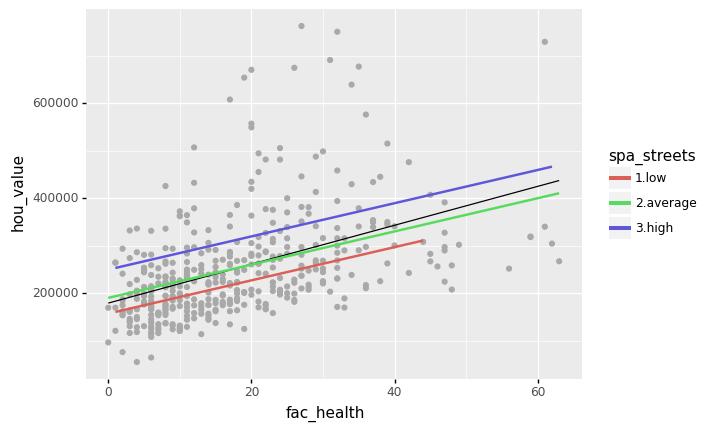

<ggplot: (162619745907)>

In [27]:
d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

# Note how we add a new geom_line with the new augmented model m, not m0
g0 + geom_line(aes(y = '_fitted', colour = 'spa_streets'), data = d, size = 1)

To model a different slope per `spa_streets` group, we simply add the interaction term:

In [28]:
m = smf.ols('hou_value ~ fac_health*spa_streets', ams).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.452e+05,1.69e+04,8.614,0.000,1.12e+05,1.78e+05
spa_streets[T.2.average],4.494e+04,2e+04,2.251,0.025,5689.682,8.42e+04
spa_streets[T.3.high],1.219e+05,3.26e+04,3.737,0.000,5.78e+04,1.86e+05
fac_health,4375.7952,1084.119,4.036,0.000,2244.623,6506.968
fac_health:spa_streets[T.2.average],-895.7433,1177.817,-0.761,0.447,-3211.107,1419.620
fac_health:spa_streets[T.3.high],-1636.6511,1519.160,-1.077,0.282,-4623.031,1349.729


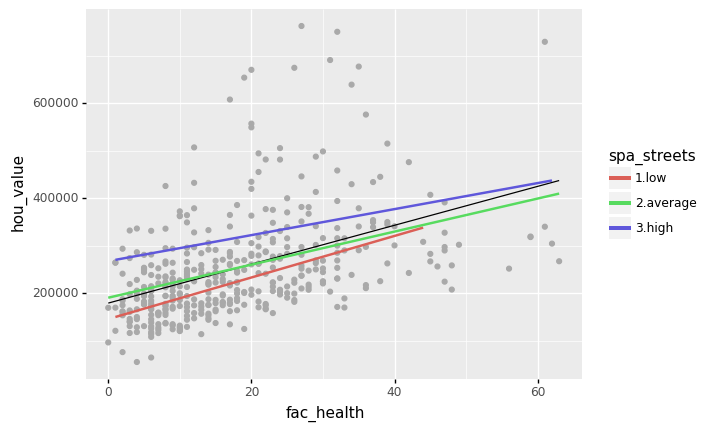

<ggplot: (162620261855)>

In [29]:
d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

g0 + geom_line(aes(y = '_fitted', colour = 'spa_streets'), data = d, size = 1)

It appears that the interaction `fac_health:spa_streets` is not statistically significant. Try making the above pot a bit better by using the `color` aesthetic to identify `spa_streets` in the points.

If it makes sense theoretically (cf. domain knowledge), we can model for example one common intercept and three different slopes as follows:

In [30]:
m = smf.ols('hou_value ~ fac_health + fac_health:spa_streets', ams).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.858e+05,8724.901,21.295,0.000,1.69e+05,2.03e+05
fac_health,2175.2472,756.759,2.874,0.004,687.625,3662.869
fac_health:spa_streets[T.2.average],1459.0413,670.265,2.177,0.030,141.448,2776.635
fac_health:spa_streets[T.3.high],3350.1864,776.973,4.312,0.000,1822.827,4877.546


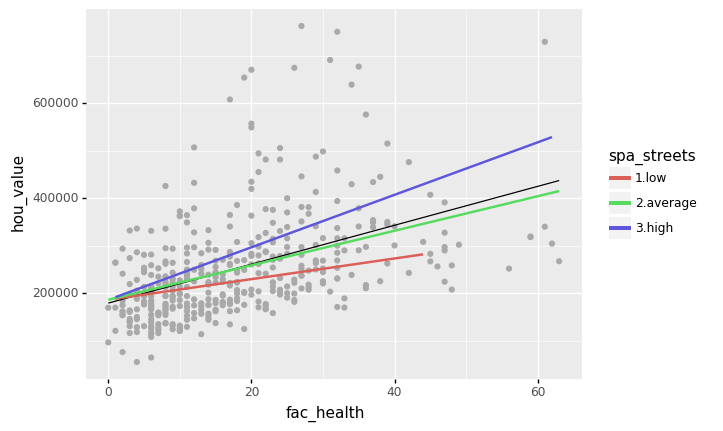

<ggplot: (162620311691)>

In [31]:
d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

g0 + geom_line(aes(y = '_fitted', colour = 'spa_streets'), data = d, size = 1)

Take a look at all the previous models and see how our claims about the effects might be different depending on which model we use. After all, we _imposed_ different restrictions on the models, so these variations are in part due to the analyst, not the data.

## 6. Non-Linear Effects

If by looking at the residuals we notice patterns, it's likely that we need to transform our data or include more variables in the model. For instance, in the simple linear model of `hou_value` by `hou_corporation`, we have the following fit and residuals:

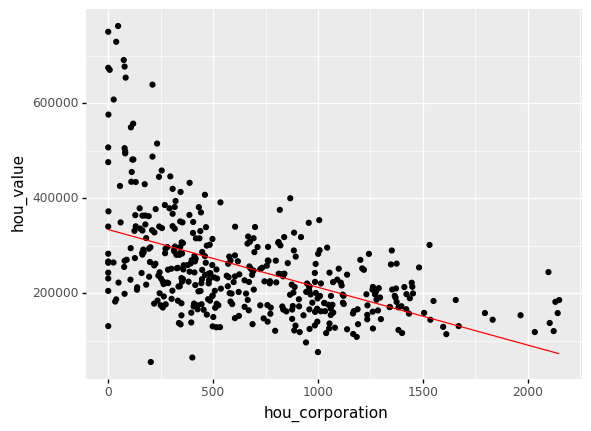

<ggplot: (162620464183)>

In [32]:
m0 = smf.ols('hou_value ~ hou_corporation', ams).fit()

d = ams.assign(_resid = m0.resid, _fitted = m0.fittedvalues)

ggplot(d, aes('hou_corporation', 'hou_value')) +\
  geom_point() +\
  geom_line(aes(y = '_fitted'), color = 'red')

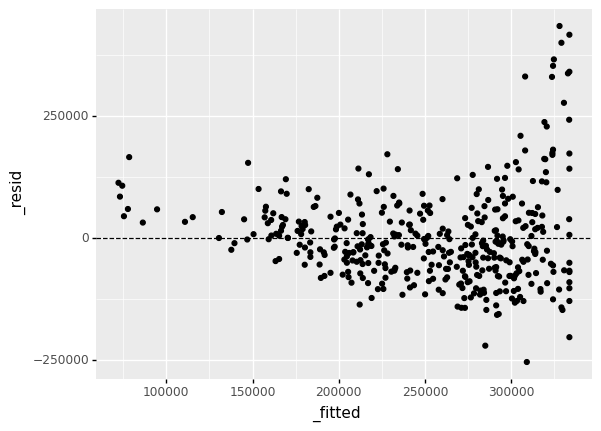

<ggplot: (162619745946)>

In [33]:
ggplot(d, aes('_fitted', '_resid')) +\
  geom_point() +\
  geom_hline(yintercept = 0,  linetype = 'dashed')

We can see that residuals tend to be positive and large for small and large fitted values, and there appears to be larger variance for larger fitted values. This suggests a polynomial transformation, so let's try a quadratic term for `hou_corporation`. For this purpose, we could try to use the `I()` function as follows: `hou_value ~ I(hou_corporation**2)` (see the final section to see what `I()` means in a model specification). Alternatively, we can use any vectorized operation on the predictors, such as Numpy's `np.power(hou_corporation, 2)` for a quadratic term. The second option is preferred because it'll make it easier to test the model on new data.

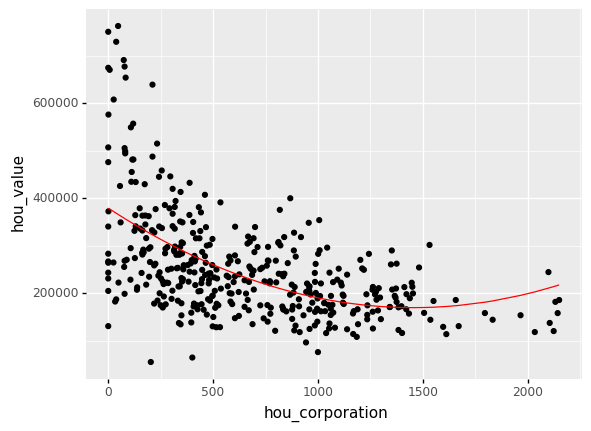

<ggplot: (162621646629)>

In [34]:
m = smf.ols('hou_value ~ hou_corporation + np.power(hou_corporation, 2)', ams).fit()

d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

ggplot(d, aes('hou_corporation', 'hou_value')) +\
  geom_point() +\
  geom_line(aes(y = '_fitted'), color = 'red')

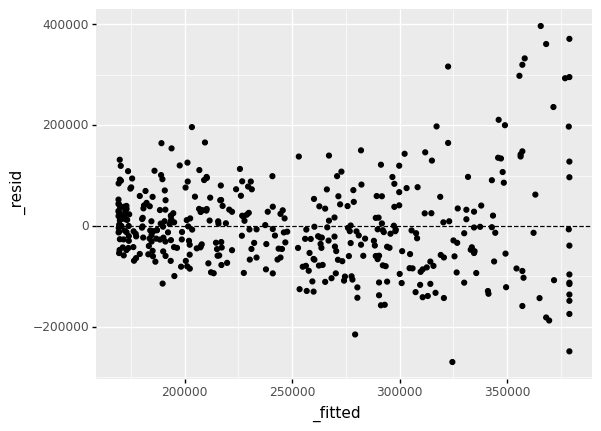

<ggplot: (162621679294)>

In [35]:
ggplot(d, aes('_fitted', '_resid')) +\
  geom_point() +\
  geom_hline(yintercept = 0,  linetype = 'dashed')

The residuals look much better after transformation, but we can still see some signs of heteroskedasticity. What transformation could we try next to solve this?

## 7. Predictions 

If we want to make predictions on new data, we can use method [`predict`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.predict.html):

In [36]:
m = smf.ols('hou_value ~ fac_health + spa_green', ams).fit()

# x_star is the data frame with new data
x_star = pd.DataFrame(data = {'fac_health': [20, 30, 30],
                              'spa_green':['3.high', '2.average', '3.high']})
y_star = m.predict(x_star)
y_star

0    302690.840648
1    288026.687971
2    340686.056803
dtype: float64

If we want to account for variability in the predictions, we can use method [`get_prediction`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.get_prediction.html) to also compute standard error (`mean_se`), confidence interval (`mean_ci_X`) and prediction interval (`obs_ci_X`):

In [37]:
y_star = m.get_prediction(x_star)
y_star.summary_frame(alpha = 0.05) # 95% intervals

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,302690.840648,10572.977932,281906.680787,323475.000509,110439.758830,494941.922465
1,288026.687971,7501.437179,273280.504775,302772.871167,96334.363978,479719.011963
2,340686.056803,11014.812818,319033.346287,362338.767318,148339.138368,533032.975238


## 8. Analysis of Variance

Of course, we can complicate models by adding more predictors and their interactions:

In [38]:
m = smf.ols('''hou_value ~ inc_income*pop_unemployed + fac_health + fac_culture +
            spa_streets + district + saf_neighbors*saf_nonneighbors''', ams).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hou_value   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     194.8
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.42e-176
Time:                        02:27:52   Log-Likelihood:                -4934.8
No. Observations:                 413   AIC:                             9904.
Df Residuals:                     396   BIC:                             9972.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                           3.782e+04   1.31e+04      2.898      0.004    1.22e+04    6.35e+04
spa_streets[T.2.average]                             783.1168   5289.703      0.148      0.882   -9616.294    1.12e+04
spa_streets[T.3.high]                              -1763.0631   7889.947     -0.223      0.823   -1.73e+04    1.37e+04
district[T.E West]                                 -5.175e+04   8053.359     -6.426      0.000   -6.76e+04   -3.59e+04
district[T.F Nieuw-West]                           -8.976e+04   9339.712     -9.610      0.000   -1.08e+05   -7.14e+04
district[T.K Zuid]                                 -2.693e+04   8421.285     -3.198      0.001   -4.35e+04   -1.04e+04
district[T.M Oost]                                 -4.898e+04   7950.628     -6.160      0.000   -6.46e+04   -3.33e+04
district[T.N Noord]                                -8.334e+04   9647.777     -8.638      0.000   -1.02e+05   -6.44e+04
district[T.T Zuidoost]                             -1.068e+05   1.03e+04    -10.414      0.000   -1.27e+05   -8.67e+04
saf_neighbors[T.2.high]                             6468.9824   5791.873      1.117      0.265   -4917.681    1.79e+04
saf_nonneighbors[T.2.high]                         -2446.8468   7555.546     -0.324      0.746   -1.73e+04    1.24e+04
saf_neighbors[T.2.high]:saf_nonneighbors[T.2.high] -3672.7413   8766.802     -0.419      0.675   -2.09e+04    1.36e+04
inc_income                                             6.7771      0.217     31.263      0.000       6.351       7.203
pop_unemployed                                        80.3069     52.075      1.542      0.124     -22.071     182.684
inc_income:pop_unemployed                             -0.0022      0.002     -1.182      0.238      -0.006       0.001
fac_health                                           295.5227    241.341      1.225      0.221    -178.946     769.992
fac_culture                                          256.3350    215.644      1.189      0.235    -167.614     680.284
==============================================================================
Omnibus:                       74.477   Durbin-Watson:                   1.436
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.607
Skew:                          -0.365   Prob(JB):                    1.03e-168
Kurtosis:                       9.665   Cond. No.                     1.03e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+08. This might indicate that there are
strong multicollinearity or other numerical probl

But the interpretations become more and more difficult. If, as usual, what we want to test hypotheses about group means while controlling for other factors, or assess how important each of the factors are (as opposed to their individual coefficients), we can run an ANOVA analysis.

There are three different ways of partitioning the total sum of squares in each of the factors, but for our purposes we will use the so-called type II:

In [39]:
anova = sm.stats.anova_lm(m, typ = 2)
anova

,sum_sq,df,F,PR(>F)
spa_streets,2.891708e+08,2.0,0.099040,9.057290e-01
district,2.121396e+11,6.0,24.218994,1.946080e-24
saf_neighbors,1.658960e+09,1.0,1.136374,2.870693e-01
saf_nonneighbors,1.797242e+09,1.0,1.231096,2.678673e-01
saf_neighbors:saf_nonneighbors,2.562198e+08,1.0,0.175509,6.754890e-01
inc_income,1.762917e+12,1.0,1207.584398,2.509079e-122
pop_unemployed,2.615922e+09,1.0,1.791886,1.814645e-01
inc_income:pop_unemployed,2.040781e+09,1.0,1.397919,2.377817e-01
fac_health,2.188948e+09,1.0,1.499412,2.214898e-01
fac_culture,2.062801e+09,1.0,1.413002,2.352710e-01


By comparing the regression table and the ANOVA table, we can see a clear difference in terms of how important each of the factors is with respect to the response. For example, it appears that `inc_income` is by far the factor with the largest effect on `hou_value`, followed by `district` and then, marginally, the others.

Additionally, the $p$-values in the ANOVA table test the hypothesis that all groups in the factor have the same population mean. For example, we would reject the hypothesis that all `district`s have the same mean `hou_value`, but we do not reject the hypothesis among the three levels of `spa_streets`.

## 9. Logistic Regression

Generalized linear models, and logistic regression in particular, can be fitted with method [`glm`](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.glm.html). It works just like `ols` for linear regression: we need to provide the data and specify the model. However, in the case of `glm`, we also need to specify the [distribution family](https://www.statsmodels.org/stable/glm.html#families) and [link function](https://www.statsmodels.org/stable/glm.html#link-functions). For logistic regression, this is done with `family = sm.families.Binomial()`, which sets the logit link by default.

Let us work with a proportion response variable, equal to the fraction of people who are unemployed in the neighborhood:

In [40]:
ams = ams.assign(unemployment = ams.pop_unemployed / ams.pop_total)

Let us fit a model with predictor `inc_income`:

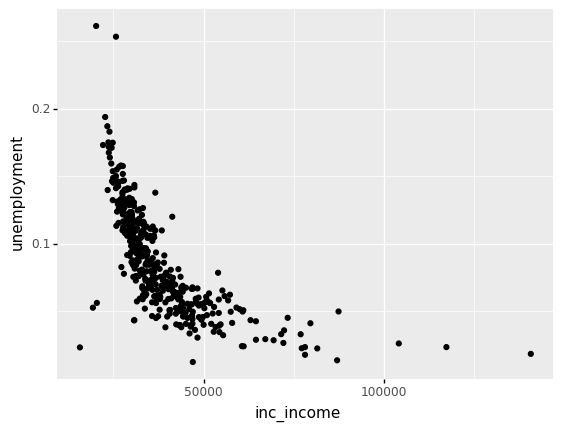

<ggplot: (162622011715)>

In [41]:
ggplot(ams, aes('inc_income', 'unemployment')) +\
  geom_point()

In [42]:
m1 = smf.glm('unemployment ~ inc_income', ams, family = sm.families.Binomial()).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           unemployment   No. Observations:                  413
Model:                            GLM   Df Residuals:                      411
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.882
Date:                Wed, 15 Dec 2021   Deviance:                       2.6975
Time:                        02:27:53   Pearson chi2:                     2.81
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01163
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9584      0.710     -1.349      0.177      -2.351       0.434
inc_income -3.867e-05   2.01e-05     -1.929      0.054    -7.8e-05    6.26e-07
==============================================================================
"""

We now have two options to diagnose the model: in the response space $[0,1]$ or in the link space $(-\infty,+\infty)$. The residuals and fitted values in the response space are accessible via `m1.resid_response` and `m1.fittedvalues`. Let's first plot the model in the response space:

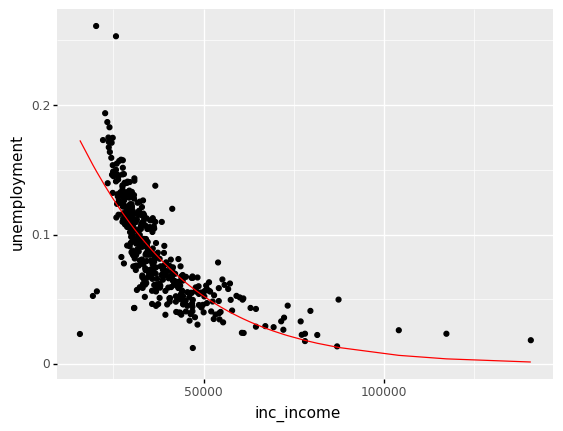

<ggplot: (162621949175)>

In [43]:
d1 = ams.assign(_resid = m1.resid_response, _fitted = m1.fittedvalues)

ggplot(d1, aes('inc_income', 'unemployment')) +\
  geom_point() +\
  geom_line(aes(y = '_fitted'), color = 'red')

If we want to diagnose the model we probably want to look at the underlying linear model in the link space. For this we typically use the _deviance_ residuals, accessible via `m1.resid_deviance`, but there is no direct access to the link fitted values in Statsmodels. Fortunately, we can compute them through the link function in `m1.family.link`. Let's take a look at residuals by fitted values:

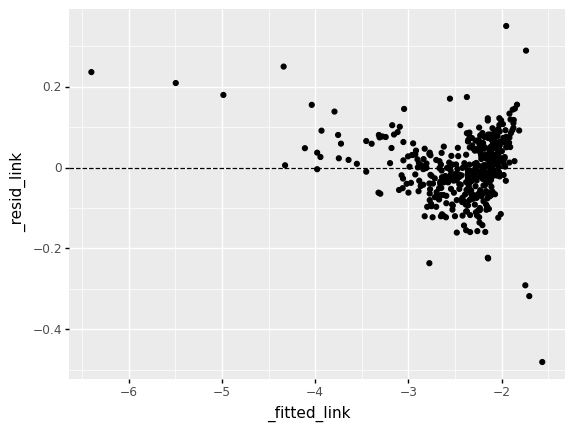

<ggplot: (162621954280)>

In [44]:
d1 = d1.assign(_resid_link = m1.resid_deviance, _fitted_link = m1.family.link(m1.fittedvalues))

ggplot(d1, aes('_fitted_link', '_resid_link')) +\
  geom_point() +\
  geom_hline(yintercept = 0,  linetype = 'dashed')

It looks like there is some non-linearity we are missing. Let's try a second model with an inverse transformation and plot again:

In [45]:
m2 = smf.glm('unemployment ~ I(1/inc_income)', ams, family = sm.families.Binomial()).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           unemployment   No. Observations:                  413
Model:                            GLM   Df Residuals:                      411
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.959
Date:                Wed, 15 Dec 2021   Deviance:                       2.8513
Time:                        02:27:53   Pearson chi2:                     2.53
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01126
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.8544      0.743     -5.185      0.000      -5.311      -2.397
I(1 / inc_income)  5.075e+04   2.35e+04      2.160      0.031    4694.894    9.68e+04
=====================================================================================
"""

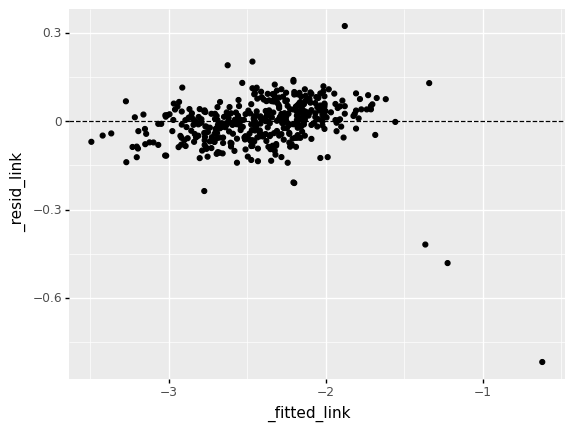

<ggplot: (162621955286)>

In [46]:
d2 = ams.assign(_resid = m2.resid_response, _fitted = m2.fittedvalues, \
               _resid_link = m2.resid_deviance, _fitted_link = m2.family.link(m2.fittedvalues))

ggplot(d2, aes('_fitted_link', '_resid_link')) +\
  geom_point() +\
  geom_hline(yintercept = 0,  linetype = 'dashed')

Looks quite better. Let us take a look at both models in the response space:

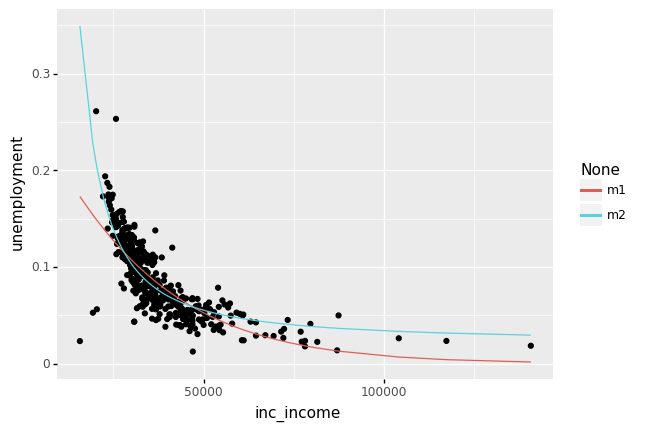

<ggplot: (162620308291)>

In [47]:
ggplot(ams, aes('inc_income', 'unemployment')) +\
  geom_point() +\
  geom_line(aes(y = '_fitted', color = ['m1']), data = d1) +\
  geom_line(aes(y = '_fitted', color = ['m2']), data = d2)

Notice how we manually labeled the `color` aesthetic above. Because underlying we just have a linear model, we can specify nominal predictors and interactions as usual. Let's try with `spa_playing`:

In [48]:
m = smf.glm('unemployment ~ I(1/inc_income)*spa_playing', ams, family = sm.families.Binomial()).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           unemployment   No. Observations:                  413
Model:                            GLM   Df Residuals:                      407
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.840
Date:                Wed, 15 Dec 2021   Deviance:                       2.6129
Time:                        02:27:53   Pearson chi2:                     2.36
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01183
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -3.2132      1.776     -1.809      0.070      -6.694       0.267
spa_playing[T.2.average]                      -0.7281      2.030     -0.359      0.720      -4.706       3.250
spa_playing[T.3.high]                         -1.1174      2.835     -0.394      0.693      -6.674       4.439
I(1 / inc_income)                           3.155e+04   5.11e+04      0.618      0.537   -6.85e+04    1.32e+05
I(1 / inc_income):spa_playing[T.2.average]  2.275e+04   5.98e+04      0.381      0.704   -9.44e+04     1.4e+05
I(1 / inc_income):spa_playing[T.3.high]     3.422e+04   9.81e+04      0.349      0.727   -1.58e+05    2.26e+05
==============================================================================================================
"""

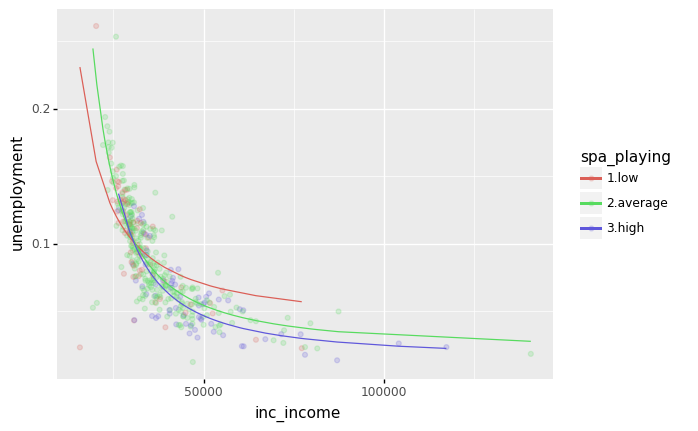

<ggplot: (162622011751)>

In [49]:
d = ams.assign(_resid = m.resid_response, _fitted = m.fittedvalues, \
               _resid_link = m.resid_deviance, _fitted_link = m.family.link(m.fittedvalues))

ggplot(d, aes('inc_income', 'unemployment', color = 'spa_playing')) +\
  geom_point(alpha = .2) +\
  geom_line(aes(y = '_fitted'))

The plot suggests a possible effect of `spa_playing`, but the model summary tells us that there is too much random error to confirm it statistically.

## 10. Model Specification Syntax

Statsmodels has a powerful but sometimes complicated language to specify models. A [full reference](https://www.statsmodels.org/stable/example_formulas.html) is available, but here are the main operations:

- `+ x`: include variable `x`.
- `- x`: remove variable `x`. This is useful when using one of the shortcuts below to include many terms at the same time.
- `x1:x2`: include the interaction between `x1` and `x2`.
- `x1*x2`: include the main effects and the interaction (same as `x1 + x2 + x1:x2`).
- `(x1 + x2 + x3 + x4)**3`: include all main effects, all two-factor interactions, and all three-factor interactions.
- `I(x1*x2)`: include a variable _as-is_, such as the arithmetic product `x1*x2` or an intentional bias like `x+3`. This is useful to do custom transformations through the model specification but without the need to pre-compute them.
- `h(x)`: include the `h`-transformation of `x`, such as `np.power`, `np.log` or `np.sqrt`. 
- `-1`: remove the intercept term.